In [1]:
import numpy as np
import pandas as pd

In [2]:
abc_df = pd.read_csv('ABC_Feature_Matrix_Random.csv')
jwst_df = pd.read_csv('Interpolated_WASP-39b.csv')

In [3]:
x_spec = abc_df.iloc[:, 1:53]
y = abc_df.iloc[:, 53]

In [4]:
x_jwst = jwst_df.iloc[:,1:]

In [5]:
#Train Test Split
from sklearn.model_selection import train_test_split
x_spec_train, x_spec_test, y_train, y_test = train_test_split(x_spec, y, test_size = 0.2, random_state = 42)

In [6]:
X_train = x_spec_train.to_numpy()
X_test = x_spec_test.to_numpy()
X_jwst = x_jwst.to_numpy()

In [7]:
#Manual Normalisation - numpy
means_tr = X_train.mean(axis=1, keepdims=True)
stds_tr = X_train.std(axis=1, keepdims=True)
x_train_norm = (X_train - means_tr) / stds_tr

means_t = X_test.mean(axis=1, keepdims=True)
stds_t = X_test.std(axis=1, keepdims=True)
x_test_norm = (X_test - means_t) / stds_t

means = X_jwst.mean(axis=1, keepdims=True)
stds = X_jwst.std(axis=1, keepdims=True)
x_jwst_norm = (X_jwst - means) / stds


In [8]:
#Manual Normalization with mean and std

x_train_norm_ms= np.hstack([x_train_norm,means_tr,stds_tr])
x_test_norm_ms = np.hstack([x_test_norm,means_t,stds_t])
x_jwst_norm_ms = np.hstack([x_jwst_norm,means,stds])

In [9]:
from sklearn.preprocessing import Normalizer

#Normalization using norm = max

scaler_norm = Normalizer(norm = 'max')

x_train_nmax = scaler_norm.fit_transform(X_train)
x_test_nmax = scaler_norm.transform(X_test)
x_jwst_nmax = scaler_norm.transform(X_jwst)

In [10]:
#Normmalization using norm = max and adding max column

x_train_nm_max = np.hstack([x_train_nmax,X_train.max(axis=1, keepdims=True)])
x_test_nm_max = np.hstack([x_test_nmax,X_test.max(axis=1, keepdims=True)])
x_jwst_nm_max = np.hstack([x_jwst_nmax,X_jwst.max(axis=1, keepdims=True)])

In [11]:
#Using Standard Scaler

from sklearn.preprocessing import StandardScaler
scaler_standard = StandardScaler()

x_train_std = scaler_standard.fit_transform(X_train)
x_test_std = scaler_standard.fit_transform(X_test)
x_jwst_std = scaler_standard.fit_transform(X_jwst)

In [12]:
y_train = y_train.to_numpy(dtype=np.float32)
y_test = y_test.to_numpy(dtype=np.float32)

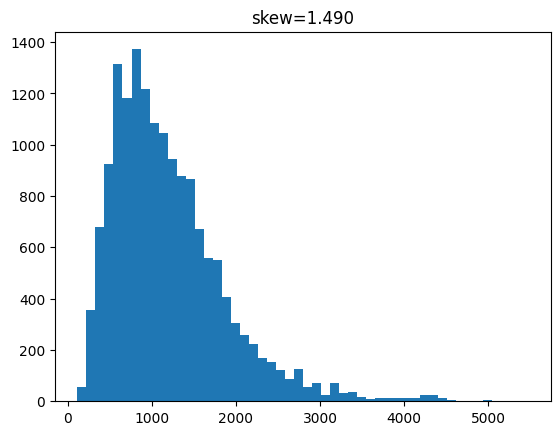

In [37]:
import matplotlib.pyplot as plt
import scipy.stats as st
plt.hist(y_train, bins=50)
plt.title(f"skew={st.skew(y_train):.3f}")
plt.show()

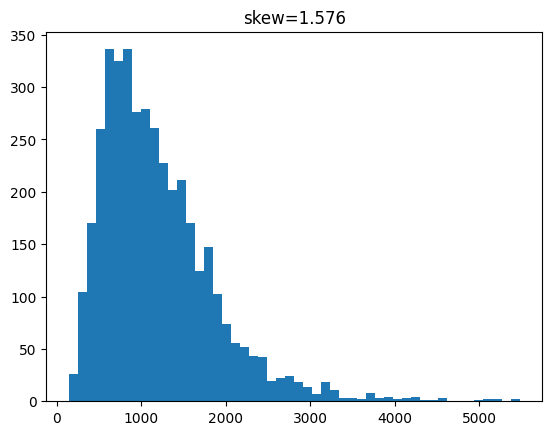

In [38]:

plt.hist(y_test, bins=50)
plt.title(f"skew={st.skew(y_test):.3f}")
plt.show()

In [13]:
y_train = np.log1p(y_train)
y_test   = np.log1p(y_test)

In [56]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_norm, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
    
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),

        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),

        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),

        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
    }

    # Single-output model
    model = xgb.XGBRegressor(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)

    # single R²
    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials= 40, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-11-27 14:22:27,424] A new study created in memory with name: no-name-0227cf15-5e08-4960-bff1-aef11c2f2938


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-27 14:22:29,606] Trial 0 finished with value: 0.9775031805038452 and parameters: {'n_estimators': 476, 'learning_rate': 0.22527836399143755, 'max_depth': 8, 'min_child_weight': 19, 'gamma': 0.12356664752456714, 'subsample': 0.42058333828849587, 'colsample_bytree': 0.48843560867701735, 'reg_alpha': 2.1737367288801055, 'reg_lambda': 6.22105984153089}. Best is trial 0 with value: 0.9775031805038452.
[I 2025-11-27 14:22:34,996] Trial 1 finished with value: 0.9791441559791565 and parameters: {'n_estimators': 751, 'learning_rate': 0.044756641130895156, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 0.13940835345501357, 'subsample': 0.6446391063029172, 'colsample_bytree': 0.9963894085850571, 'reg_alpha': 4.137911406731128, 'reg_lambda': 7.902891442070849}. Best is trial 1 with value: 0.9791441559791565.
[I 2025-11-27 14:22:41,829] Trial 2 finished with value: 0.9856883883476257 and parameters: {'n_estimators': 1008, 'learning_rate': 0.10972514789480263, 'max_depth': 7, 'min_child_

In [57]:
best_norm = study.best_params
best_norm["objective"] = "reg:squarederror"
best_norm["verbosity"] = 0
best_norm["n_jobs"] = -1

xgb_norm = xgb.XGBRegressor(**best_norm)
xgb_norm.fit(x_train_norm, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.936358171263125
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [18]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_norm_ms, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
    
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),

        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),

        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),

        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),

    }

    # Single-output model
    model = xgb.XGBRegressor(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)

    # single R²
    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials= 40, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-11-27 13:37:02,223] A new study created in memory with name: no-name-c66d55a9-5608-48a4-b70e-0b09c3be19c1


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-27 13:37:06,375] Trial 0 finished with value: 0.977253794670105 and parameters: {'n_estimators': 1440, 'learning_rate': 0.09395115228282246, 'max_depth': 8, 'min_child_weight': 20, 'gamma': 0.9206335989044191, 'subsample': 0.8407112067573317, 'colsample_bytree': 0.6450938887532582, 'reg_alpha': 1.7147412565460274, 'reg_lambda': 8.06394893514883}. Best is trial 0 with value: 0.977253794670105.
[I 2025-11-27 13:37:10,118] Trial 1 finished with value: 0.9607545137405396 and parameters: {'n_estimators': 1362, 'learning_rate': 0.26523285486094, 'max_depth': 8, 'min_child_weight': 1, 'gamma': 0.6796487453774407, 'subsample': 0.5317544004304642, 'colsample_bytree': 0.7253194347682574, 'reg_alpha': 8.139121244767916, 'reg_lambda': 5.235559105428402}. Best is trial 0 with value: 0.977253794670105.
[I 2025-11-27 13:37:13,120] Trial 2 finished with value: 0.9794350862503052 and parameters: {'n_estimators': 863, 'learning_rate': 0.04549426539125174, 'max_depth': 7, 'min_child_weight': 3

In [19]:
best_norm_ms = study.best_params
best_norm_ms["objective"] = "reg:squarederror"
best_norm_ms["verbosity"] = 0
best_norm_ms["n_jobs"] = -1

xgb_norm_ms = xgb.XGBRegressor(**best_norm_ms)
xgb_norm_ms.fit(x_train_norm_ms, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9983268425775538
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [72]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_nmax, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
    
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),

        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),

        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),

        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),

    }

    # Single-output model
    model = xgb.XGBRegressor(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)

    # single R²
    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials= 40, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-11-27 14:35:25,952] A new study created in memory with name: no-name-b0453fae-42fa-4407-8868-d381fb371c45


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-27 14:35:30,519] Trial 0 finished with value: 0.8715472221374512 and parameters: {'n_estimators': 1019, 'learning_rate': 0.23075315002305488, 'max_depth': 9, 'min_child_weight': 17, 'gamma': 0.5690889520129125, 'subsample': 0.5505823995864365, 'colsample_bytree': 0.41270043571770515, 'reg_alpha': 7.5806089114838295, 'reg_lambda': 0.25474940410557645}. Best is trial 0 with value: 0.8715472221374512.
[I 2025-11-27 14:35:33,812] Trial 1 finished with value: 0.88834148645401 and parameters: {'n_estimators': 463, 'learning_rate': 0.1753522853481078, 'max_depth': 10, 'min_child_weight': 6, 'gamma': 0.5492091932886344, 'subsample': 0.6258518768738918, 'colsample_bytree': 0.8549617406378911, 'reg_alpha': 6.951004751690228, 'reg_lambda': 5.375183105471329}. Best is trial 1 with value: 0.88834148645401.
[I 2025-11-27 14:35:38,689] Trial 2 finished with value: 0.9070983529090881 and parameters: {'n_estimators': 749, 'learning_rate': 0.12071508606064817, 'max_depth': 5, 'min_child_weigh

In [73]:
best_nmax = study.best_params
best_nmax["objective"] = "reg:squarederror"
best_nmax["verbosity"] = 0
best_nmax["n_jobs"] = -1

xgb_nmax = xgb.XGBRegressor(**best_nmax)
xgb_nmax.fit(x_train_nmax, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.9987610234408668
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [22]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from xgboost.callback import EarlyStopping
import xgboost as xgb

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_nm_max, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
        "n_estimators": trial.suggest_int("n_estimators", 400, 900),
        "learning_rate": trial.suggest_float("learning_rate", 0.05, 0.15),
        "max_depth": trial.suggest_int("max_depth", 5, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 6),
        "gamma": trial.suggest_float("gamma", 0.0, 0.3),
        "subsample": trial.suggest_float("subsample", 0.7, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 3.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0),
        "n_jobs": -1,
        "random_state": 42

    }

    # Single-output model
    model = xgb.XGBRegressor(**params)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )

    preds = model.predict(X_val)

    # single R²
    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.NopPruner()
)

study.optimize(objective, n_trials= 50, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-11-27 13:42:37,049] A new study created in memory with name: no-name-5874531a-df77-411c-8e8e-74e19bbbe6a2


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-27 13:42:39,964] Trial 0 finished with value: 0.934741199016571 and parameters: {'n_estimators': 535, 'learning_rate': 0.05537450506229753, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.24982703165508358, 'subsample': 0.8864226051397627, 'colsample_bytree': 0.9667160300494659, 'reg_alpha': 0.03450520114968081, 'reg_lambda': 0.9303482327604856}. Best is trial 0 with value: 0.934741199016571.
[I 2025-11-27 13:42:46,642] Trial 1 finished with value: 0.9570841789245605 and parameters: {'n_estimators': 840, 'learning_rate': 0.06775723854028844, 'max_depth': 8, 'min_child_weight': 3, 'gamma': 0.004810239551924567, 'subsample': 0.9522494355470883, 'colsample_bytree': 0.7925115966851202, 'reg_alpha': 1.8250595689130764, 'reg_lambda': 0.440069713998148}. Best is trial 1 with value: 0.9570841789245605.
[I 2025-11-27 13:42:50,751] Trial 2 finished with value: 0.9482093453407288 and parameters: {'n_estimators': 769, 'learning_rate': 0.050749822821818814, 'max_depth': 6, 'min_child_w

In [23]:
best_nm_max = study.best_params
best_nm_max["objective"] = "reg:squarederror"
best_nm_max["verbosity"] = 0
best_nm_max["n_jobs"] = -1

xgb_nm_max = xgb.XGBRegressor(**best_nm_max)
xgb_nm_max.fit(x_train_nm_max, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7620015500663924
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [44]:
import optuna
import numpy as np
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    x_train_std, y_train, test_size=0.20, random_state=42
)

def objective(trial):

    params = {
        "objective": "reg:squarederror",
        "verbosity": 0,
    
        "n_estimators": trial.suggest_int("n_estimators", 300, 1500),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),

        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),

        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),

        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),

    }

    # Single-output model
    model = xgb.XGBRegressor(**params)
    model.fit(X_tr, y_tr)

    preds = model.predict(X_val)

    # single R²
    r2 = r2_score(y_val, preds)

    trial.report(r2, step=0)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return r2


study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(),
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials= 40, show_progress_bar=True)

print("Best R2:", study.best_value)
print("Best Params:", study.best_params)


[I 2025-11-27 13:56:49,475] A new study created in memory with name: no-name-feafdcd5-27ba-443d-a375-f39654762f44


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-11-27 13:57:06,421] Trial 0 finished with value: 0.6848480701446533 and parameters: {'n_estimators': 631, 'learning_rate': 0.015247912248149195, 'max_depth': 12, 'min_child_weight': 9, 'gamma': 0.13466431998709527, 'subsample': 0.6063671338237775, 'colsample_bytree': 0.779088453793287, 'reg_alpha': 2.258448400072556, 'reg_lambda': 7.640346607361263}. Best is trial 0 with value: 0.6848480701446533.
[I 2025-11-27 13:57:15,518] Trial 1 finished with value: 0.606814980506897 and parameters: {'n_estimators': 1218, 'learning_rate': 0.0734534763750171, 'max_depth': 6, 'min_child_weight': 4, 'gamma': 0.2685177808652751, 'subsample': 0.8707190048339681, 'colsample_bytree': 0.9806308943588398, 'reg_alpha': 4.081981451430854, 'reg_lambda': 9.60677497910865}. Best is trial 0 with value: 0.6848480701446533.
[I 2025-11-27 13:57:21,317] Trial 2 finished with value: 0.555774986743927 and parameters: {'n_estimators': 894, 'learning_rate': 0.2197317553093989, 'max_depth': 4, 'min_child_weight': 

In [45]:
best_std = study.best_params
best_std["objective"] = "reg:squarederror"
best_std["verbosity"] = 0
best_std["n_jobs"] = -1

xgb_std = xgb.XGBRegressor(**best_std)
xgb_std.fit(x_train_std, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.5676130592292107
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [14]:
import joblib

# suppose your trained model is 'model'
xgb_norm = joblib.load( "xgb_norm.pkl")
xgb_norm_ms= joblib.load( "xgb_norm_ms.pkl")
xgb_nmax=joblib.load( "xgb_nmax.pkl")
xgb_nm_max=joblib.load("xgb_nm_max.pkl")
xgb_std= joblib.load( "xgb_std.pkl")

In [15]:
y_test_pred_norm =  xgb_norm.predict(x_test_norm)
y_test_pred_norm_ms =  xgb_norm_ms.predict(x_test_norm_ms)
y_test_pred_nmax =  xgb_nmax.predict(x_test_nmax)
y_test_pred_nm_max =  xgb_nm_max.predict(x_test_nm_max)
y_test_pred_std =  xgb_std.predict(x_test_std)

In [16]:
y_train_pred_norm =  xgb_norm.predict(x_train_norm)
y_train_pred_norm_ms =  xgb_norm_ms.predict(x_train_norm_ms)
y_train_pred_nmax =  xgb_nmax.predict(x_train_nmax)
y_train_pred_nm_max =  xgb_nm_max.predict(x_train_nm_max)
y_train_pred_std =  xgb_std.predict(x_train_std)

In [17]:
from sklearn.metrics import r2_score

results = {
    "xgb_norm": [r2_score(y_train, xgb_norm.predict(x_train_norm)), r2_score(y_test, xgb_norm.predict(x_test_norm))],
    "xgb_norm_ms": [r2_score(y_train, xgb_norm_ms.predict(x_train_norm_ms)), r2_score(y_test, xgb_norm_ms.predict(x_test_norm_ms))],
    "xgb_nmax": [r2_score(y_train, xgb_nmax.predict(x_train_nmax)), r2_score(y_test, xgb_nmax.predict(x_test_nmax))],
    "xgb_nm_max": [r2_score(y_train, xgb_nm_max.predict(x_train_nm_max)), r2_score(y_test, xgb_nm_max.predict(x_test_nm_max))],
    "xgb_std": [r2_score(y_train, xgb_std.predict(x_train_std)), r2_score(y_test, xgb_std.predict(x_test_std))]
}

In [18]:
result_df = pd.DataFrame(results, index=["train", "test"])
result_df

,xgb_norm,xgb_norm_ms,xgb_nmax,xgb_nm_max,xgb_std
train,0.998376,0.997520,0.995415,0.995647,0.966263
test,0.992720,0.992279,0.969961,0.969122,-20.054277


In [23]:
from sklearn.metrics import mean_absolute_error

results_mae = {
    "xgb_norm": [mean_absolute_error(y_train, xgb_norm.predict(x_train_norm)), mean_absolute_error(y_test, xgb_norm.predict(x_test_norm))],
    "xgb_norm_ms": [mean_absolute_error(y_train, xgb_norm_ms.predict(x_train_norm_ms)), mean_absolute_error(y_test, xgb_norm_ms.predict(x_test_norm_ms))],
    "xgb_nmax": [mean_absolute_error(y_train, xgb_nmax.predict(x_train_nmax)), mean_absolute_error(y_test, xgb_nmax.predict(x_test_nmax))],
    "xgb_nm_max": [mean_absolute_error(y_train, xgb_nm_max.predict(x_train_nm_max)),mean_absolute_error(y_test, xgb_nm_max.predict(x_test_nm_max))],
    "xgb_std": [mean_absolute_error(y_train, xgb_std.predict(x_train_std)), mean_absolute_error(y_test, xgb_std.predict(x_test_std))]
}

result_mae_df = pd.DataFrame(results_mae, index=["train", "test"])
result_mae_df

,xgb_norm,xgb_norm_ms,xgb_nmax,xgb_nm_max,xgb_std
train,0.015570,0.020084,0.023275,0.024458,0.068734
test,0.028596,0.030991,0.055629,0.055696,1.849270


In [24]:
from sklearn.metrics import mean_squared_error

results_mse = {
    "xgb_norm": [mean_squared_error(y_train, xgb_norm.predict(x_train_norm)), mean_squared_error(y_test, xgb_norm.predict(x_test_norm))],
    "xgb_norm_ms": [mean_squared_error(y_train, xgb_norm_ms.predict(x_train_norm_ms)), mean_squared_error(y_test, xgb_norm_ms.predict(x_test_norm_ms))],
    "xgb_nmax": [mean_squared_error(y_train, xgb_nmax.predict(x_train_nmax)), mean_squared_error(y_test, xgb_nmax.predict(x_test_nmax))],
    "xgb_nm_max": [mean_squared_error(y_train, xgb_nm_max.predict(x_train_nm_max)),mean_squared_error(y_test, xgb_nm_max.predict(x_test_nm_max))],
    "xgb_std": [mean_squared_error(y_train, xgb_std.predict(x_train_std)), mean_squared_error(y_test, xgb_std.predict(x_test_std))]
}

result_mse_df = pd.DataFrame(results_mse, index=["train", "test"])
result_mse_df

,xgb_norm,xgb_norm_ms,xgb_nmax,xgb_nm_max,xgb_std
train,0.000501,0.000765,0.001414,0.001343,0.010406
test,0.002205,0.002338,0.009098,0.009352,6.376701


In [30]:
result_rmse_df = np.sqrt(result_mse_df)
result_rmse_df

,xgb_norm,xgb_norm_ms,xgb_nmax,xgb_nm_max,xgb_std
train,0.022383,0.027660,0.037606,0.036641,0.102010
test,0.046956,0.048357,0.095383,0.096706,2.525213


In [19]:
y_norm = np.expm1(xgb_norm.predict(x_jwst_norm))
y_norm_ms = np.expm1(xgb_norm_ms.predict(x_jwst_norm_ms))
y_nmax = np.expm1(xgb_nmax.predict(x_jwst_nmax))
y_nm_max = np.expm1(xgb_nm_max.predict(x_jwst_nm_max))
y_std = np.expm1(xgb_std.predict(x_jwst_std))

In [20]:
print("XGB NORM : ", y_norm.mean(axis = 0))
print("XGB NORM MS : ", y_norm_ms.mean(axis = 0))
print("XGB NMAX: ", y_nmax.mean(axis = 0))
print("XGB NM MAX : ", y_nm_max.mean(axis = 0))
print("XGB STD : ", y_std.mean(axis = 0))

XGB NORM :  605.3809
XGB NORM MS :  580.2129
XGB NMAX:  627.30145
XGB NM MAX :  958.4037
XGB STD :  1331.4222


In [80]:
print("xgb norm params : ",best_norm)
print("xgb norm ms params : ",best_norm_ms)
print("xgb nmax params : ",best_nmax)
print("xgb nm max params : ",best_nm_max)
print("xgb std params : ",best_std)

xgb norm params :  {'n_estimators': 1407, 'learning_rate': 0.09526809849086519, 'max_depth': 11, 'min_child_weight': 13, 'gamma': 0.0012225648023497567, 'subsample': 0.8264702199603964, 'colsample_bytree': 0.936358171263125, 'reg_alpha': 0.8570801384148861, 'reg_lambda': 4.6796374554728555, 'objective': 'reg:squarederror', 'verbosity': 0, 'n_jobs': -1}
xgb norm ms params :  {'n_estimators': 1500, 'learning_rate': 0.12453229362500987, 'max_depth': 7, 'min_child_weight': 16, 'gamma': 0.003253261374263769, 'subsample': 0.7427284099855457, 'colsample_bytree': 0.9983268425775538, 'reg_alpha': 0.7250437066241899, 'reg_lambda': 5.974280712302016, 'objective': 'reg:squarederror', 'verbosity': 0, 'n_jobs': -1}
xgb nmax params :  {'n_estimators': 913, 'learning_rate': 0.15238629660924097, 'max_depth': 10, 'min_child_weight': 8, 'gamma': 0.002343688270022284, 'subsample': 0.46589108372482885, 'colsample_bytree': 0.9987610234408668, 'reg_alpha': 0.5948467192854933, 'reg_lambda': 7.4009732193786375

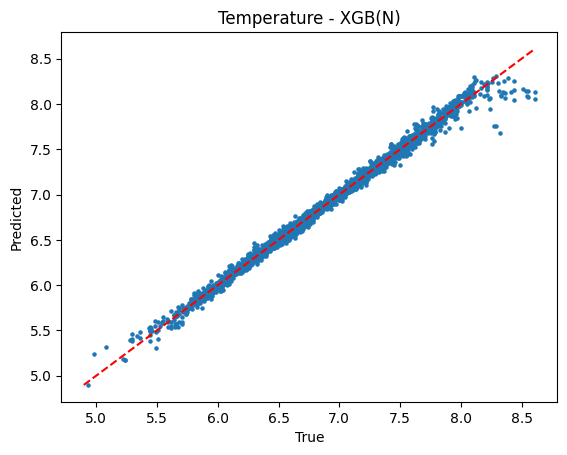

In [60]:
plt.figure()
plt.scatter(y_test, y_test_pred_norm, s=5)

m = min(y_test.min(), y_test_pred_norm.min())
M = max(y_test.max(), y_test_pred_norm.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature - XGB(N)")
plt.show()

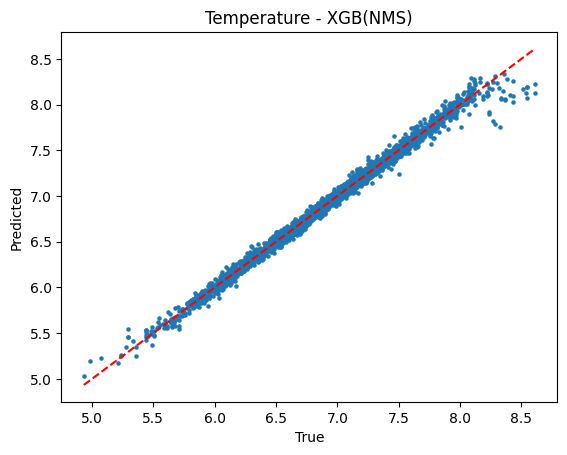

In [61]:
plt.figure()
plt.scatter(y_test, y_test_pred_norm_ms, s=5)

m = min(y_test.min(), y_test_pred_norm_ms.min())
M = max(y_test.max(), y_test_pred_norm_ms.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature - XGB(NMS)")
plt.show()

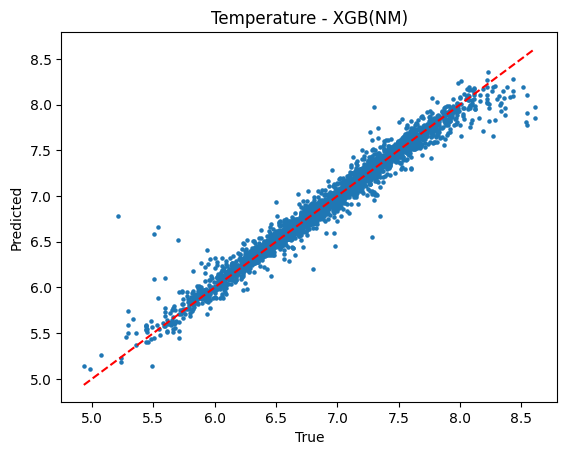

In [62]:
plt.figure()
plt.scatter(y_test, y_test_pred_nmax, s=5)

m = min(y_test.min(), y_test_pred_nmax.min())
M = max(y_test.max(), y_test_pred_nmax.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature - XGB(NM)")
plt.show()

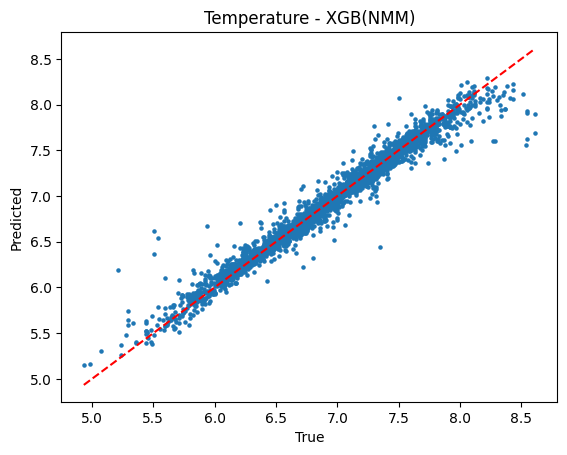

In [63]:
plt.figure()
plt.scatter(y_test, y_test_pred_nm_max, s=5)

m = min(y_test.min(), y_test_pred_nm_max.min())
M = max(y_test.max(), y_test_pred_nm_max.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature - XGB(NMM)")
plt.show()

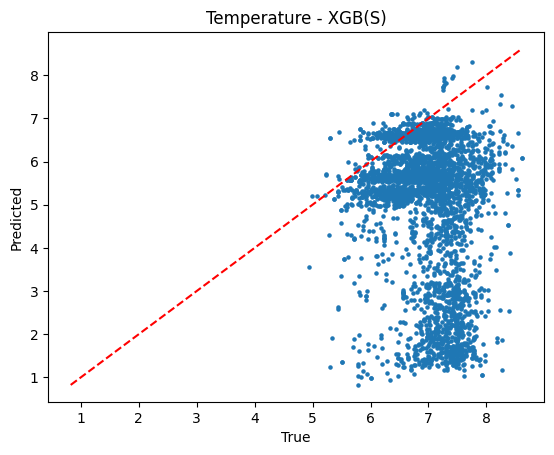

In [64]:
plt.figure()
plt.scatter(y_test, y_test_pred_std, s=5)

m = min(y_test.min(), y_test_pred_std.min())
M = max(y_test.max(), y_test_pred_std.max())

plt.plot([m, M], [m, M], 'r--')
    
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Temperature - XGB(S)")
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\349092842.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\349092842.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\349092842.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

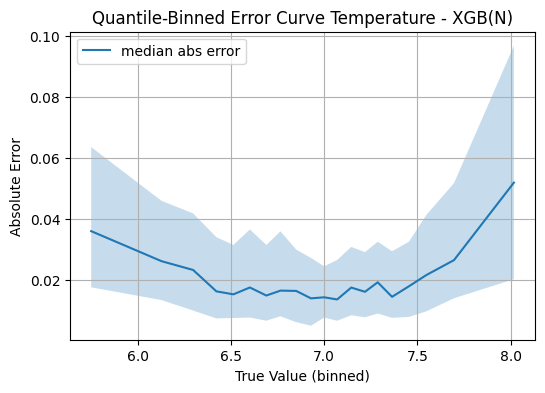

In [65]:
true = y_test       # 1D array
pred = y_test_pred_norm  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature - XGB(N)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\1150962491.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\1150962491.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\1150962491.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

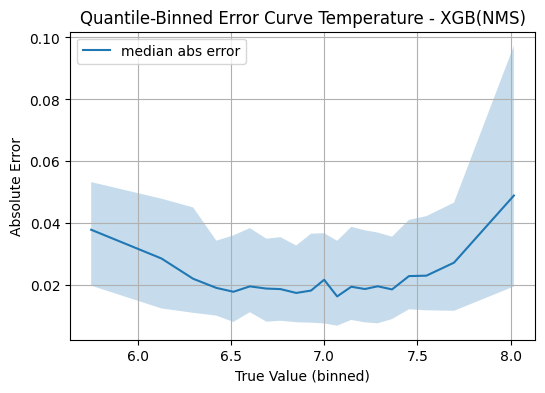

In [66]:
true = y_test       # 1D array
pred = y_test_pred_norm_ms  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature - XGB(NMS)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\2992460825.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\2992460825.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\2992460825.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

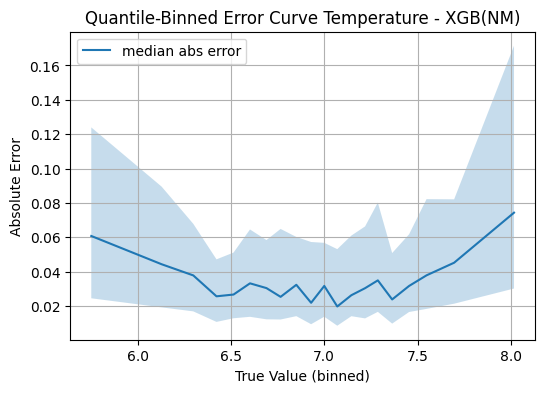

In [67]:
true = y_test       # 1D array
pred = y_test_pred_nmax  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature - XGB(NM)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\794569902.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\794569902.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\794569902.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and sile

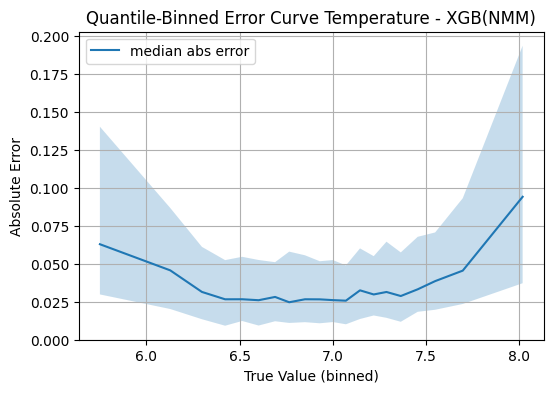

In [68]:
true = y_test       # 1D array
pred = y_test_pred_nm_max  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature - XGB(NMM)")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\2750648661.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df.groupby("bin")["true"].mean()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\2750648661.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_err   = df.groupby("bin")["err"].median()
C:\Users\Hamshith\AppData\Local\Temp\ipykernel_17924\2750648661.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and s

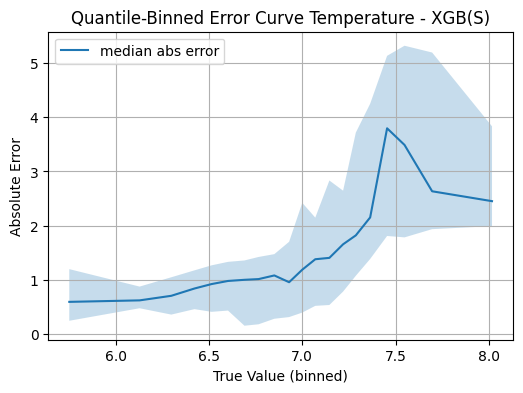

In [69]:
true = y_test       # 1D array
pred = y_test_pred_std  # 1D array

errors = np.abs(true - pred)

# Number of quantile bins (same as paper: ~20 bins)
num_bins = 20

# Bin according to TRUE values
df = pd.DataFrame({"true": true, "err": errors})
df["bin"] = pd.qcut(df["true"], q=num_bins, duplicates="drop")

# Compute stats inside each bin
bin_centers = df.groupby("bin")["true"].mean()
median_err   = df.groupby("bin")["err"].median()
low_err      = df.groupby("bin")["err"].quantile(0.25)   # lower quartile
high_err     = df.groupby("bin")["err"].quantile(0.75)   # upper quartile

plt.figure(figsize=(6,4))

# Shaded region = IQR (or use std if you prefer)
plt.fill_between(
    bin_centers,
    low_err,
    high_err,
    alpha=0.25
)

# Median error curve
plt.plot(bin_centers, median_err, label="median abs error")

plt.xlabel("True Value (binned)")
plt.ylabel("Absolute Error")
plt.title("Quantile-Binned Error Curve Temperature - XGB(S)")
plt.legend()
plt.grid(True)
plt.show()

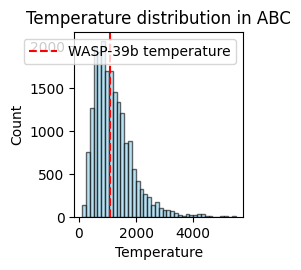

In [92]:
plt.subplot(2, 3, 1)
plt.hist(y, bins=40, alpha=0.6, color='skyblue', edgecolor='k')
plt.axvline(1100, color='red', linestyle='--', label= "WASP-39b temperature")
plt.title(f"Temperature distribution in ABC")
plt.xlabel("Temperature")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [93]:
import joblib

# suppose your trained model is 'model'
joblib.dump(xgb_norm, "xgb_norm.pkl")
joblib.dump(xgb_norm_ms, "xgb_norm_ms.pkl")
joblib.dump(xgb_nmax, "xgb_nmax.pkl")
joblib.dump(xgb_nm_max, "xgb_nm_max.pkl")
joblib.dump(xgb_std, "xgb_std.pkl")

['xgb_std.pkl']